住宅の様々な条件から最終価格を予測するコンペ

In [3]:
# データ処理ラブラり
import numpy as np
import pandas as pd
 
# データ可視化ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline 
 
 #LightGBM
import lightgbm as lgb
 
# Scikit-learn（評価算出）
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

/anaconda3/lib/python3.5/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
cd ..

/Users/hasegawatakashikana


In [3]:
cd Downloads/house-prices-advanced-regression-techniques/

/Users/hasegawatakashikana/Downloads/house-prices-advanced-regression-techniques


In [4]:
# 訓練データの読み込み
df_train = pd.read_csv('train.csv')
df_test =pd.read_csv('test.csv')
 


In [5]:
import os

#matplotlibみたいなやつ
import seaborn as sns 
import matplotlib.pyplot as plt
#正規分布をつくるやつ
from scipy.stats import norm
from scipy import stats
#標準化
from sklearn.preprocessing import StandardScaler
#実行に影響のなwarningを非表示にする
import warnings
warnings.filterwarnings('ignore')
#ノートブック上にグラフを描画するという意味
%matplotlib inline

In [6]:
train = pd.read_csv('train.csv')
test =pd.read_csv('test.csv')

In [7]:
print(train["RoofMatl"].unique())
print(test["RoofMatl"].unique())

['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl']


In [8]:
df_train.shape

(1460, 81)

In [9]:
df_test.shape

(1459, 80)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


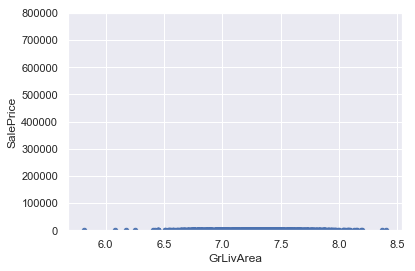

In [113]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [10]:
#df_trainから２つの条件に該当する要素を削除(外れ値)
df_train = df_train.drop(df_train[(df_train["GrLivArea"]>4000 )&(df_train["SalePrice"]<300000)].index)

In [11]:
#予測値を除いたtrainとtestを結合
df_all = df_train.drop(["SalePrice"],axis=1).append(df_test)

In [12]:
df_all.shape

(2917, 80)

In [13]:
df_train.drop(["SalePrice"],axis=1).append(df_test)[:1458].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [14]:
df_all.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [15]:
df_all.isnull().count().head()

Id             2917
MSSubClass     2917
MSZoning       2917
LotFrontage    2917
LotArea        2917
dtype: int64

In [16]:
#df_all.isnull().count()はNAN値を含む全要素数（今回は2917）
total = df_all.isnull().sum()/df_all.isnull().count()
#列毎の欠損値の総数
sum =df_all.isnull().sum()
total.head()

Id             0.000000
MSSubClass     0.000000
MSZoning       0.001371
LotFrontage    0.166610
LotArea        0.000000
dtype: float64

In [17]:
sum.head()

Id               0
MSSubClass       0
MSZoning         4
LotFrontage    486
LotArea          0
dtype: int64

In [18]:
#totalとsumを「"Perc","Sum"」という名前で横に並べてPerc(total)でソートする
#つまりmissingは欠損データランキングみたいなもん
missing = pd.concat([total,sum],axis=1,keys=["Perc","Sum"]).sort_values(by="Perc",ascending=False)

In [19]:
#colstdropはmissingから欠損値が１つ以上存在するものを抜き出したもののインデックス
colstdrop = missing[missing["Sum"]>0].index
missing[missing["Sum"]>0]

,Perc,Sum
PoolQC,0.996915,2908
MiscFeature,0.964004,2812
Alley,0.932122,2719
Fence,0.804251,2346
FireplaceQu,0.486802,1420
LotFrontage,0.166610,486
GarageYrBlt,0.054508,159
GarageFinish,0.054508,159
GarageQual,0.054508,159
GarageCond,0.054508,159


In [20]:
#欠損値をNoneで穴埋め
df_all["MiscFeature"]=df_all["MiscFeature"].fillna("None")
df_all["Alley"]=df_all["Alley"].fillna("None")
df_all["Fence"]=df_all["Fence"].fillna("None")
df_all["FireplaceQu"]=df_all["FireplaceQu"].fillna("None")
df_all["GarageFinish"]=df_all["GarageFinish"].fillna("None")
df_all["GarageQual"]=df_all["GarageFinish"].fillna("None")
df_all["GarageType"]=df_all["GarageType"].fillna("None")
df_all["BsmtCond"]=df_all["BsmtCond"].fillna("None")
df_all["BsmtExposure"]=df_all["BsmtExposure"].fillna("None")
df_all["BsmtQual"]=df_all["BsmtQual"].fillna("None")
df_all['BsmtFinType2']=df_all['BsmtFinType2'].fillna("None")
df_all['BsmtFinType1']=df_all['BsmtFinType1'].fillna("None")
df_all['GarageCond']=df_all['GarageCond'].fillna("None")
df_all['PoolQC']=df_all['PoolQC'].fillna("None")
df_all['MasVnrType']=df_all['MasVnrType'].fillna("None")
df_all['MasVnrArea']=df_all['MasVnrArea'].fillna(0)
df_all['Functional']=df_all['Functional'].fillna("Typ")
#df_all['Utilities']=df_all['Utilities'].fillna("AllPub")
df_all=df_all.drop(['Utilities'],axis=1)
df_all['MSZoning']=df_all['MSZoning'].fillna(df_all['MSZoning'].mode()[0])
df_all['Electrical']=df_all['Electrical'].fillna(df_all['Electrical'].mode()[0])
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ['GarageYrBlt','GarageArea','GarageCars']:
    df_all[col]=df_all[col].fillna(0)
    
for col in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']:
    df_all[col]=df_all[col].fillna(0)
    
for col in ['SaleType','Exterior1st','Exterior2nd','KitchenQual']:
    df_all[col]=df_all[col].fillna(df_all[col].mode()[0])

In [21]:
#同種のパラメータをまとめてる
df_all['Total_sqr_footage'] = (df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] +
                                 df_all['1stFlrSF'] + df_all['2ndFlrSF'])

df_all['Total_Bathrooms'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                               df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))

df_all['Total_porch_sf'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                              df_all['EnclosedPorch'] + df_all['ScreenPorch'] +
                              df_all['WoodDeckSF'])

In [22]:
df_all.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,...,None,None,0,2,2008,WD,Normal,2416.0,3.5,61
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,...,None,None,0,5,2007,WD,Normal,2240.0,2.5,298
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,...,None,None,0,9,2008,WD,Normal,2272.0,3.5,42
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,...,None,None,0,2,2006,WD,Abnorml,1933.0,2.0,307
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,...,None,None,0,12,2008,WD,Normal,2853.0,3.5,276


In [23]:
#これでNAN値はなくなった（NoneはOKなのね）
df_all.isna().sum().sort_values(ascending=False).head()

Total_porch_sf    0
RoofStyle         0
Exterior1st       0
Exterior2nd       0
MasVnrType        0
dtype: int64

In [24]:
df_all["BsmtFinSF1"]

0        706.0
1        978.0
2        486.0
3        216.0
4        655.0
5        732.0
6       1369.0
7        859.0
8          0.0
9        851.0
10       906.0
11       998.0
12       737.0
13         0.0
14       733.0
15         0.0
16       578.0
17         0.0
18       646.0
19       504.0
20         0.0
21         0.0
22         0.0
23       840.0
24       188.0
25         0.0
26       234.0
27      1218.0
28      1277.0
29         0.0
         ...  
1429       0.0
1430       0.0
1431       0.0
1432       0.0
1433       0.0
1434    1573.0
1435    1564.0
1436     776.0
1437       0.0
1438       0.0
1439     576.0
1440     909.0
1441    1136.0
1442    1350.0
1443    1455.0
1444       0.0
1445    1243.0
1446       0.0
1447     441.0
1448     149.0
1449     522.0
1450     252.0
1451     119.0
1452     408.0
1453       0.0
1454       0.0
1455     252.0
1456    1224.0
1457     337.0
1458     758.0
Name: BsmtFinSF1, Length: 2917, dtype: float64

In [25]:
colstdrop.shape

(34,)

In [26]:
df_all.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckS

In [27]:
#IDを削除
df_all =df_all.drop(["Id"],axis=1)
df_all["Totalarea"] = df_all["TotalBsmtSF"] + df_all["1stFlrSF"] + df_all["2ndFlrSF"]

In [28]:
#値が数値
numericcols = df_all.dtypes[df_all.dtypes != object]
#値が定量評価不能
categorcols = df_all.dtypes[df_all.dtypes == object]

In [29]:
numericcols.index

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'Total_sqr_footage', 'Total_Bathrooms',
       'Total_porch_sf', 'Totalarea'],
      dtype='object')

In [30]:
categorcols.index

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [31]:
#選び方は不明(categorcolsが多い？)
catcols=('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
         'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir',  'OverallCond', 'OverallQual',
        #'YrSold',  'GarageYrBlt','YearRemodAdd',
        'YrSold', 'MoSold','MSSubClass')

In [32]:
catcols

('FireplaceQu',
 'BsmtQual',
 'BsmtCond',
 'GarageQual',
 'GarageCond',
 'ExterQual',
 'ExterCond',
 'HeatingQC',
 'PoolQC',
 'KitchenQual',
 'BsmtFinType1',
 'BsmtFinType2',
 'Functional',
 'Fence',
 'BsmtExposure',
 'GarageFinish',
 'LandSlope',
 'LotShape',
 'PavedDrive',
 'Street',
 'Alley',
 'CentralAir',
 'OverallCond',
 'OverallQual',
 'YrSold',
 'MoSold',
 'MSSubClass')

In [33]:
df_all.shape

(2917, 82)

In [115]:
df_all.dtypes[df_all.dtypes == "object"].index

Index([], dtype='object')

In [35]:
print(df_all.dtypes.unique())
print(df_all["MSSubClass"].dtypes)

df_all["MSSubClass"]

[dtype('int64') dtype('O') dtype('float64')]
int64


0        60
1        20
2        60
3        70
4        60
5        50
6        20
7        60
8        50
9       190
10       20
11       60
12       20
13       20
14       20
15       45
16       20
17       90
18       20
19       20
20       60
21       45
22       20
23      120
24       20
25       20
26       20
27       20
28       20
29       30
       ... 
1429     30
1430     50
1431     30
1432    190
1433     50
1434    120
1435    120
1436     20
1437     90
1438     20
1439     80
1440     20
1441     20
1442     20
1443     20
1444     20
1445     90
1446    160
1447     20
1448     90
1449    180
1450    160
1451     20
1452    160
1453    160
1454    160
1455    160
1456     20
1457     85
1458     60
Name: MSSubClass, Length: 2917, dtype: int64

In [36]:
#数値から文字扱いにしている
df_all["MSSubClass"]=df_all["MSSubClass"].apply(str)

In [37]:
df_all["MSSubClass"].head()

0    60
1    20
2    60
3    70
4    60
Name: MSSubClass, dtype: object

In [38]:
from scipy import stats
from scipy.stats import norm,skew

numeric_feats = df_all.dtypes[df_all.dtypes != "object"].index
#dropnaは欠損値を削除するメソッド
skewed_feats = df_all[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")

skewness = pd.DataFrame({"Skew" :skewed_feats})
skewness.head(10)
print(skewness.shape)


Skew in numerical features: 

(39, 1)


In [39]:
#偏りがある程度より大きいものだけ残した
skewness = skewness[abs(skewness["Skew"])>0.20]
print(skewness.shape)


(35, 1)


In [40]:
numeric_feats

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'Total_sqr_footage', 'Total_Bathrooms',
       'Total_porch_sf', 'Totalarea'],
      dtype='object')

In [41]:
df_all["MiscVal"].skew()

21.95096155903538

In [42]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
skewed_features = skewness.index
#正規分布に近づける処理
#λが1より大きい場合は小さな値の間隔が圧縮され、小さい場合は大きな値の間隔が圧縮されるように変換される
lam = 0.15
for feat in skewed_features:
    df_all[feat] = boxcox1p(df_all[feat],boxcox_normmax(df_all[feat]+1))

In [43]:
numeric_feats = df_all.dtypes[df_all.dtypes != "object"].index

skewed_feats = df_all[numeric_feats].apply(lambda x :skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({"Skew" :skewed_feats})
skewness

,Skew
PoolArea,15.595057
3SsnPorch,8.862045
LowQualFinSF,8.492615
MiscVal,5.237983
BsmtHalfBath,3.779434
KitchenAbvGr,3.778336
ScreenPorch,3.152631
BsmtFinSF2,2.578329
EnclosedPorch,2.149133
MasVnrArea,0.977618


In [44]:
def encode(frame,feature):
    ordering = pd.DataFrame()
    ordering["val"] = df_all[feature].unique()
    ordering.index = ordering.val
    ordering["spmean"] = frame[[feature,"SalePrice"]].groupby(feature).mean()["SalePrice"]
    ordering = ordering.sort_values("spmean")
    ordering["ordering"] = range(1,ordering.shape[0]+1)
    ordering = ordering["ordering"].to_dict()
    
    for cat,o in ordering.items():
        df_all.loc[df_all[feature]==cat,feature+"E"] = str(o)

In [45]:
qual_encoded =[]
for q in catcols :
    encode(df_train,q)
print(qual_encoded)

[]


In [46]:
df_all.shape

(2917, 109)

In [47]:
df_all.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,LotShapeE,PavedDriveE,StreetE,AlleyE,CentralAirE,OverallCondE,OverallQualE,YrSoldE,MoSoldE,MSSubClassE
0,60,RL,18.144572,13.833055,Pave,None,Reg,Lvl,Inside,Gtl,...,1,3,2,3,2,1,7,2,4,1
1,20,RL,20.673625,14.117919,Pave,None,Reg,Lvl,FR2,Gtl,...,1,3,2,3,2,2,6,5,2,2
2,60,RL,18.668046,14.476514,Pave,None,IR1,Lvl,Inside,Gtl,...,2,3,2,3,2,1,7,2,12,1
3,70,RL,17.249650,14.106198,Pave,None,IR1,Lvl,Corner,Gtl,...,2,3,2,3,2,1,7,4,4,3
4,60,RL,21.314282,15.022009,Pave,None,IR1,Lvl,FR2,Gtl,...,2,3,2,3,2,1,8,2,10,1


In [48]:
df_train[["MSZoning","SalePrice"]].groupby("MSZoning").mean()

,SalePrice
MSZoning,
C (all),74528.000000
FV,214014.061538
RH,131558.375000
RL,191037.422977
RM,126316.830275


In [49]:
df_all.isna().sum().sort_values(ascending=False)

MSSubClassE          0
CentralAir           0
BsmtQual             0
BsmtCond             0
BsmtExposure         0
BsmtFinType1         0
BsmtFinSF1           0
BsmtFinType2         0
BsmtFinSF2           0
BsmtUnfSF            0
TotalBsmtSF          0
Heating              0
HeatingQC            0
Electrical           0
Functional           0
1stFlrSF             0
2ndFlrSF             0
LowQualFinSF         0
GrLivArea            0
BsmtFullBath         0
BsmtHalfBath         0
FullBath             0
HalfBath             0
BedroomAbvGr         0
KitchenAbvGr         0
KitchenQual          0
Foundation           0
ExterCond            0
ExterQual            0
MasVnrArea           0
                    ..
OverallQualE         0
YrSoldE              0
FireplaceQuE         0
Totalarea            0
Total_porch_sf       0
Total_Bathrooms      0
GarageType           0
GarageYrBlt          0
GarageFinish         0
GarageCars           0
GarageArea           0
GarageQual           0
GarageCond 

In [50]:
skewed_feats

PoolArea             15.595057
3SsnPorch             8.862045
LowQualFinSF          8.492615
MiscVal               5.237983
BsmtHalfBath          3.779434
KitchenAbvGr          3.778336
ScreenPorch           3.152631
BsmtFinSF2            2.578329
EnclosedPorch         2.149133
MasVnrArea            0.977618
2ndFlrSF              0.895453
WoodDeckSF            0.785550
HalfBath              0.732625
GarageYrBlt           0.701801
OpenPorchSF           0.621231
BsmtFullBath          0.616643
Fireplaces            0.553135
OverallCond           0.382457
BsmtFinSF1            0.365986
TotalBsmtSF           0.297009
GarageArea            0.199655
MoSold                0.197345
OverallQual           0.189591
Total_porch_sf        0.186828
FullBath              0.165514
YrSold                0.131996
Total_Bathrooms       0.119268
LotFrontage           0.059189
BsmtUnfSF             0.054195
TotRmsAbvGrd          0.047190
BedroomAbvGr          0.036048
Totalarea             0.028465
GrLivAre

In [51]:
df_all.shape

(2917, 109)

In [52]:
df_all["haspool"] = df_all["PoolArea"].apply(lambda x:1 if x>0 else 0)
df_all["has2ndfloor"] = df_all["2ndFlrSF"].apply(lambda x:1 if x>0 else 0)
df_all["hasgarage"] = df_all["GarageArea"].apply(lambda x:1 if x>0 else 0)
df_all["hasbsmt"] = df_all["TotalBsmtSF"].apply(lambda x:1 if x>0 else 0)
df_all["hasfireplace"] = df_all["Fireplaces"].apply(lambda x:1 if x>0 else 0)

In [53]:
df_all = pd.get_dummies(df_all).reset_index(drop=True)
df_all.shape

(2917, 473)

In [54]:
df_all.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MSSubClassE_15,MSSubClassE_16,MSSubClassE_2,MSSubClassE_3,MSSubClassE_4,MSSubClassE_5,MSSubClassE_6,MSSubClassE_7,MSSubClassE_8,MSSubClassE_9
0,18.144572,13.833055,7,3.991517,2.737675e+51,1.520678e+151,19.433174,144.117862,0.0,29.991052,...,0,0,0,0,0,0,0,0,0,0
1,20.673625,14.117919,6,6.000033,2.205286e+51,8.115884e+150,0.000000,181.719186,0.0,44.135410,...,0,0,1,0,0,0,0,0,0,0
2,18.668046,14.476514,7,3.991517,2.694440e+51,1.485946e+151,17.768840,110.441033,0.0,56.896528,...,0,0,0,0,0,0,0,0,0,0
3,17.249650,14.106198,7,3.991517,1.338046e+51,7.050662e+150,0.000000,61.795315,0.0,64.808848,...,0,0,0,1,0,0,0,0,0,0
4,21.314282,15.022009,8,3.991517,2.673064e+51,1.418793e+151,25.404163,136.624601,0.0,61.166371,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df_all.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'MSSubClassE_15', 'MSSubClassE_16', 'MSSubClassE_2', 'MSSubClassE_3',
       'MSSubClassE_4', 'MSSubClassE_5', 'MSSubClassE_6', 'MSSubClassE_7',
       'MSSubClassE_8', 'MSSubClassE_9'],
      dtype='object', length=473)

In [56]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LassoCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#from sklearn.linear_model import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
linreg = LinearRegression()

In [59]:
for cat in df_all.columns:
    print(cat)

print(df_train["RoofMatl"].unique())
print(df_train["RoofMatl"].unique())

LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
Total_sqr_footage
Total_Bathrooms
Total_porch_sf
Totalarea
haspool
has2ndfloor
hasgarage
hasbsmt
hasfireplace
MSSubClass_120
MSSubClass_150
MSSubClass_160
MSSubClass_180
MSSubClass_190
MSSubClass_20
MSSubClass_30
MSSubClass_40
MSSubClass_45
MSSubClass_50
MSSubClass_60
MSSubClass_70
MSSubClass_75
MSSubClass_80
MSSubClass_85
MSSubClass_90
MSZoning_C (all)
MSZoning_FV
MSZoning_RH
MSZoning_RL
MSZoning_RM
Street_Grvl
Street_Pave
Alley_Grvl
Alley_None
Alley_Pave
LotShape_IR1
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_Bnk
LandContour_HLS
LandContour_Low
LandContour_Lvl
LotConfig_Corner
LotConfig_CulDSac
LotConf

In [60]:
df_all

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MSSubClassE_15,MSSubClassE_16,MSSubClassE_2,MSSubClassE_3,MSSubClassE_4,MSSubClassE_5,MSSubClassE_6,MSSubClassE_7,MSSubClassE_8,MSSubClassE_9
0,18.144572,13.833055,7,3.991517,2.737675e+51,1.520678e+151,19.433174,144.117862,0.000000,29.991052,...,0,0,0,0,0,0,0,0,0,0
1,20.673625,14.117919,6,6.000033,2.205286e+51,8.115884e+150,0.000000,181.719186,0.000000,44.135410,...,0,0,1,0,0,0,0,0,0,0
2,18.668046,14.476514,7,3.991517,2.694440e+51,1.485946e+151,17.768840,110.441033,0.000000,56.896528,...,0,0,0,0,0,0,0,0,0,0
3,17.249650,14.106198,7,3.991517,1.338046e+51,7.050662e+150,0.000000,61.795315,0.000000,64.808848,...,0,0,0,1,0,0,0,0,0,0
4,21.314282,15.022009,8,3.991517,2.673064e+51,1.418793e+151,25.404163,136.624601,0.000000,61.166371,...,0,0,0,0,0,0,0,0,0,0
5,21.472480,14.998258,5,3.991517,2.527820e+51,1.263635e+151,0.000000,147.876483,0.000000,17.718036,...,0,0,0,0,1,0,0,0,0,0
6,19.854050,14.228590,8,3.991517,2.759535e+51,1.592542e+151,18.962283,230.755721,0.000000,47.147306,...,0,0,1,0,0,0,0,0,0,0
7,20.673625,14.294346,7,4.679500,2.152537e+51,7.564951e+150,21.355330,165.705771,4.749196,37.422800,...,0,0,0,0,0,0,0,0,0,0
8,15.558090,13.126989,7,3.991517,1.527738e+51,4.397354e+150,0.000000,0.000000,0.000000,90.703475,...,0,0,0,0,1,0,0,0,0,0
9,15.362900,13.546137,5,4.679500,1.631770e+51,4.397354e+150,0.000000,164.606644,0.000000,28.754166,...,0,0,0,0,0,1,0,0,0,0


In [61]:
data_input = df_all[:1458]
data_test = df_all[1458:]
data_output = np.log1p(df_train["SalePrice"]).values
data_output.shape

(1458,)

In [62]:
data_test.shape

(1459, 473)

In [63]:
data_output

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [64]:
print(data_input.shape)
print(data_test.shape)
print(data_output.shape)

(1458, 473)
(1459, 473)
(1458,)


In [65]:
#validation function
n_folds =5

def rmsle_cv(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(data_input.values)
    rmse = np.sqrt(-cross_val_score(model,data_input.values,data_output,scoring="neg_mean_squared_error",cv=kf))
    print(cross_val_score(model,data_input.values,data_output,scoring="neg_mean_squared_error",cv=kf))
    return(rmse)

In [66]:
linreg.fit(data_input,data_output)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [67]:
rmsle_cv(linreg).mean()

[-0.09987854 -0.12612762 -0.10503293 -0.10146491 -0.11762359]


0.3313533073957612

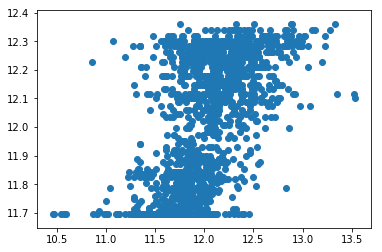

In [68]:
fig,ax =plt.subplots()
ax.scatter(x=data_output,y=linreg.predict(data_input))

In [69]:
linreg_output = linreg.predict(data_test)

In [70]:
linreg_output[abs(linreg_output)>15]

array([], dtype=float64)

In [71]:
type(data_input)

pandas.core.frame.DataFrame

In [72]:
data_input.iloc[120:290]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MSSubClassE_15,MSSubClassE_16,MSSubClassE_2,MSSubClassE_3,MSSubClassE_4,MSSubClassE_5,MSSubClassE_6,MSSubClassE_7,MSSubClassE_8,MSSubClassE_9
120,20.754413,15.988858,6,3.991517,2.084043e+51,6.886959e+150,0.000000,176.403936,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
121,15.362900,13.105741,4,3.991517,1.631770e+51,4.397354e+150,0.000000,0.000000,0.000000,77.639340,...,0,0,0,0,1,0,0,0,0,0
122,19.854050,14.085906,6,5.348040,1.906067e+51,5.314445e+150,16.296732,123.741119,0.000000,62.641215,...,0,0,1,0,0,0,0,0,0,0
123,16.323758,13.681850,6,3.991517,2.527820e+51,1.206334e+151,0.000000,78.223363,0.000000,87.683327,...,0,0,0,0,0,0,0,0,1,0
124,14.967694,15.439784,6,3.991517,2.259244e+51,1.354613e+151,0.000000,0.000000,0.000000,112.045856,...,0,0,1,0,0,0,0,0,0,0
125,17.249650,13.348963,6,6.000033,1.578951e+51,9.338060e+150,0.000000,111.088921,0.000000,10.925327,...,0,0,0,0,0,1,0,0,0,0
126,9.537243,12.664036,6,3.991517,2.205286e+51,8.115884e+150,0.000000,40.433513,0.000000,91.040886,...,0,0,0,0,0,0,0,0,1,0
127,16.323758,12.419629,5,5.348040,1.515180e+51,4.397354e+150,0.000000,39.451921,0.000000,65.944287,...,0,0,0,0,0,0,1,0,0,0
128,18.840431,13.595900,6,3.991517,2.034018e+51,6.417844e+150,22.396171,114.625028,0.000000,29.746491,...,0,0,0,0,0,0,0,0,0,0
129,18.840431,13.966727,5,5.348040,1.906067e+51,1.151577e+151,13.033801,123.276492,4.519960,55.236466,...,0,0,1,0,0,0,0,0,0,0


In [73]:
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
kfolds = KFold(n_splits=10,shuffle=True,random_state=42)
lasso = make_pipeline(RobustScaler(),LassoCV(max_iter=1e7,alphas=alphas2,random_state=42,cv=kfolds))
lasso.fit(data_input,data_output)

lasso_output_train = lasso.predict(data_input)
lasso_output = lasso.predict(data_test)
print(rmsle_cv(lasso).mean())
print(rmsle_cv(lasso).std())

[-0.01101863 -0.011937   -0.01431613 -0.00999397 -0.01176813]
0.10846543424177899
[-0.01101863 -0.011937   -0.01431613 -0.00999397 -0.01176813]
0.006482540191293548


In [74]:
resid =abs(lasso_output_train-data_output)

In [75]:
out_mean = abs(lasso_output_train-data_output).mean()
out_std =abs(lasso_output_train-data_output).std()
z = (resid-out_mean)/out_std
#out_border
z = np.array(z)
outliers = np.where(abs(z)>1.3*abs(z).std())[0]
outliers

array([   3,    4,   13,   17,   30,   38,   48,   66,   70,   76,   88,
         97,  107,  142,  154,  175,  181,  185,  193,  218,  223,  225,
        238,  242,  251,  261,  268,  275,  277,  286,  307,  308,  313,
        318,  328,  329,  330,  335,  347,  348,  365,  371,  377,  378,
        380,  393,  397,  401,  410,  418,  431,  439,  445,  451,  457,
        462,  473,  479,  488,  495,  507,  512,  534,  543,  548,  557,
        558,  559,  580,  582,  587,  588,  606,  607,  625,  627,  631,
        657,  661,  665,  668,  680,  687,  704,  706,  709,  710,  713,
        714,  715,  725,  727,  737,  743,  746,  770,  771,  773,  788,
        796,  802,  807,  808,  811,  854,  863,  869,  873,  884,  895,
        897,  914,  915,  934,  939,  941,  944,  962,  967,  969,  971,
        989,  996,  999, 1021, 1029, 1045, 1048, 1061, 1064, 1067, 1079,
       1091, 1121, 1130, 1138, 1142, 1144, 1162, 1177, 1180, 1181, 1182,
       1183, 1184, 1199, 1201, 1210, 1211, 1246, 12

In [76]:
data_input_drop_out = data_input.drop([3,    4,   13,   17,   30,   38,   48,   66,   70,   76,   88,
         97,  107,  142,  154,  175,  181,  185,  193,  218,  223,  225,
        238,  242,  251,  261,  268,  275,  277,  286,  307,  308,  313,
        318,  328,  329,  330,  335,  347,  348,  365,  371,  377,  378,
        380,  393,  397,  401,  410,  418,  431,  439,  445,  451,  457,
        462,  473,  479,  488,  495,  507,  512,  534,  543,  548,  557,
        558,  559,  580,  582,  587,  588,  606,  607,  625,  627,  631,
        657,  661,  665,  668,  680,  687,  704,  706,  709,  710,  713,
        714,  715,  725,  727,  737,  743,  746,  770,  771,  773,  788,
        796,  802,  807,  808,  811,  854,  863,  869,  873,  884,  895,
        897,  914,  915,  934,  939,  941,  944,  962,  967,  969,  971,
        989,  996,  999, 1021, 1029, 1045, 1048, 1061, 1064, 1067, 1079,
       1091, 1121, 1130, 1138, 1142, 1144, 1162, 1177, 1180, 1181, 1182,
       1183, 1184, 1199, 1201, 1210, 1211, 1246, 1251, 1261, 1302, 1320,
       1322, 1323, 1335, 1342, 1343, 1357, 1376, 1378, 1381, 1384, 1413,
       1421, 1430, 1451])
data_output_drop_out = np.delete(data_output,[3,    4,   13,   17,   30,   38,   48,   66,   70,   76,   88,
         97,  107,  142,  154,  175,  181,  185,  193,  218,  223,  225,
        238,  242,  251,  261,  268,  275,  277,  286,  307,  308,  313,
        318,  328,  329,  330,  335,  347,  348,  365,  371,  377,  378,
        380,  393,  397,  401,  410,  418,  431,  439,  445,  451,  457,
        462,  473,  479,  488,  495,  507,  512,  534,  543,  548,  557,
        558,  559,  580,  582,  587,  588,  606,  607,  625,  627,  631,
        657,  661,  665,  668,  680,  687,  704,  706,  709,  710,  713,
        714,  715,  725,  727,  737,  743,  746,  770,  771,  773,  788,
        796,  802,  807,  808,  811,  854,  863,  869,  873,  884,  895,
        897,  914,  915,  934,  939,  941,  944,  962,  967,  969,  971,
        989,  996,  999, 1021, 1029, 1045, 1048, 1061, 1064, 1067, 1079,
       1091, 1121, 1130, 1138, 1142, 1144, 1162, 1177, 1180, 1181, 1182,
       1183, 1184, 1199, 1201, 1210, 1211, 1246, 1251, 1261, 1302, 1320,
       1322, 1323, 1335, 1342, 1343, 1357, 1376, 1378, 1381, 1384, 1413,
       1421, 1430, 1451],0)

In [77]:
pd.set_option("display.max_columns",500)
pd.set_option("display.width",1000)
data_input_drop_out.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,Totalarea,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functi

In [78]:
print(data_output_drop_out.shape)
print(data_input_drop_out.shape)

(1290,)
(1290, 473)


In [79]:
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
kfolds = KFold(n_splits=10,shuffle=True,random_state=42)
lasso = make_pipeline(RobustScaler(),LassoCV(max_iter=1e7,alphas=alphas2,random_state=42,cv=kfolds))
lasso.fit(data_input_drop_out,data_output_drop_out)

lasso_output = lasso.predict(data_test)

print(np.sqrt(-cross_val_score(lasso,data_input_drop_out,data_output_drop_out,cv=5,scoring="neg_mean_squared_error")).mean())
print(np.sqrt(-cross_val_score(lasso,data_input,data_output,cv=5,scoring="neg_mean_squared_error")).mean())


0.06217955664912683
0.10846543424177899


In [80]:
print(df_all.shape)

(2917, 473)


In [81]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=13)
rr.fit(data_input_drop_out,data_output_drop_out)
np.sqrt(-cross_val_score(lasso,data_input_drop_out,data_output_drop_out,cv=5,scoring="neg_mean_squared_error")).mean()

0.06217955664912683

In [82]:
testids = df_test["Id"]

In [83]:
lasso_output = lasso.predict(data_test)
test_output = lasso_output

In [84]:
results = pd.concat([testids,pd.Series(np.expm1(test_output))],axis=1,keys=["Id","SalePrice"])

In [85]:
results.head()

,Id,SalePrice
0,1461,119147.526627
1,1462,163079.574900
2,1463,192801.993775
3,1464,205969.059869
4,1465,193062.022420


In [86]:
results.to_csv("../submissionslassooutlierremoval16.csv",index=False)

やり方その２！

In [87]:
df_train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [88]:
df_train = pd.read_csv('train.csv')

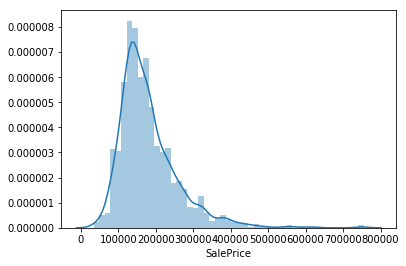

In [89]:
sns.distplot(df_train['SalePrice']);

In [90]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


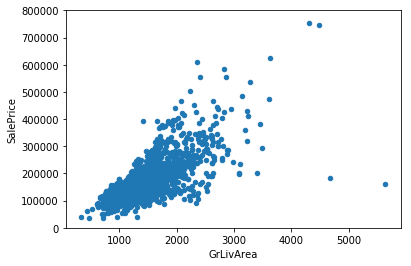

In [91]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train[var],df_train['SalePrice']], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

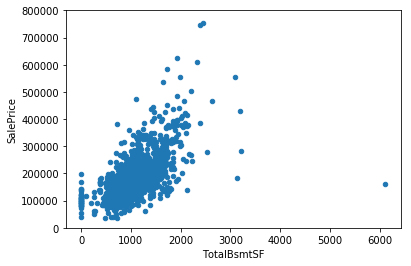

In [92]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

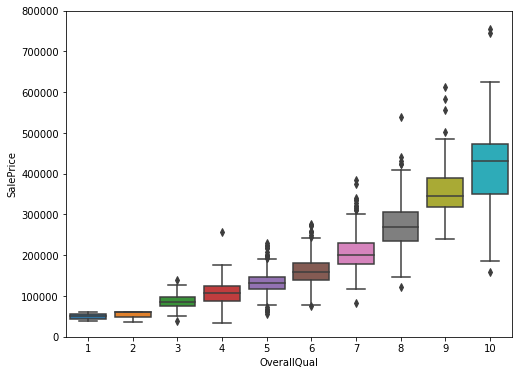

In [93]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

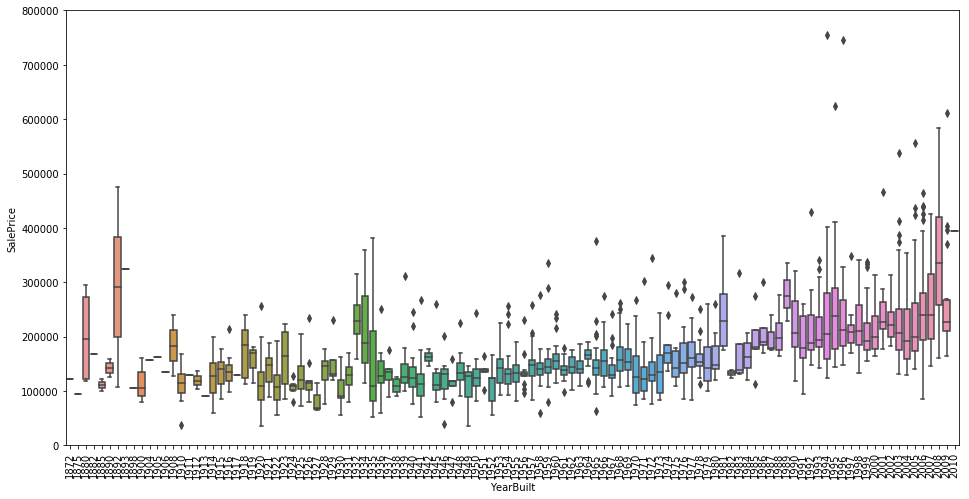

In [94]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In [95]:
corrmat = df_train.corr()

In [96]:
corrmat

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

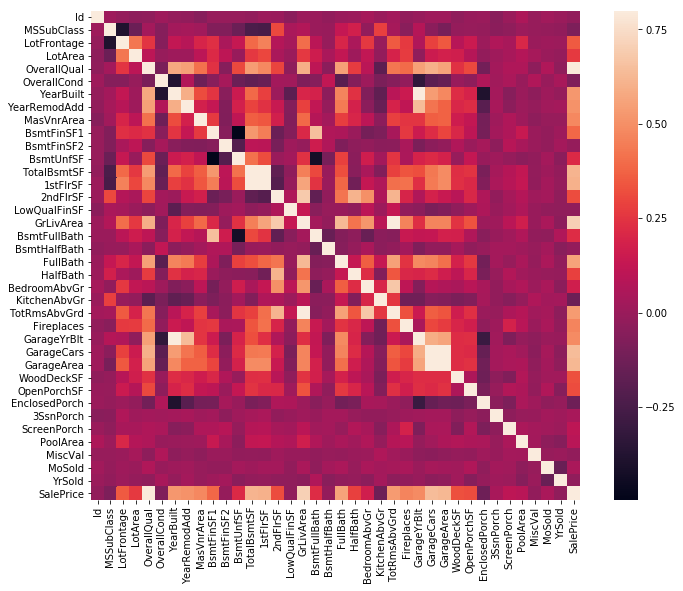

In [97]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Index(['cols: SalePrice', 'cols: OverallQual', 'cols: GrLivArea', 'cols: GarageCars', 'cols: GarageArea', 'cols: TotalBsmtSF', 'cols: 1stFlrSF', 'cols: FullBath', 'cols: TotRmsAbvGrd', 'cols: YearBuilt'], dtype='object')
[[1.         0.7909816  0.70862448 0.6404092  0.62343144 0.61358055
  0.60585218 0.56066376 0.53372316 0.52289733]
 [0.7909816  1.         0.59300743 0.60067072 0.56202176 0.5378085
  0.47622383 0.55059971 0.42745234 0.57232277]
 [0.70862448 0.59300743 1.         0.46724742 0.46899748 0.4548682
  0.56602397 0.63001165 0.82548937 0.19900971]
 [0.6404092  0.60067072 0.46724742 1.         0.88247541 0.43458483
  0.43931681 0.46967204 0.36228857 0.53785009]
 [0.62343144 0.56202176 0.46899748 0.88247541 1.         0.48666546
  0.48978165 0.40565621 0.33782212 0.47895382]
 [0.61358055 0.5378085  0.4548682  0.43458483 0.48666546 1.
  0.81952998 0.32372241 0.28557256 0.391452  ]
 [0.60585218 0.47622383 0.56602397 0.43931681 0.48978165 0.81952998
  1.         0.38063749 0.40951

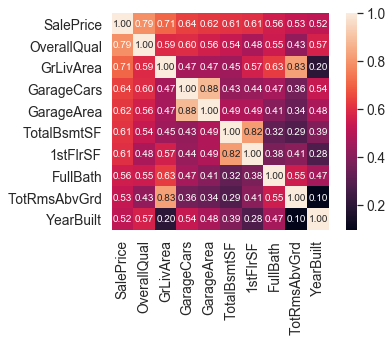

In [98]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
print("cols: "+cols)
cm = np.corrcoef(df_train[cols].values.T)
print(cm)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [100]:
df_train[cols].values

array([[208500,      7,   1710, ...,      2,      8,   2003],
       [181500,      6,   1262, ...,      2,      6,   1976],
       [223500,      7,   1786, ...,      2,      6,   2001],
       ...,
       [266500,      7,   2340, ...,      2,      9,   1941],
       [142125,      5,   1078, ...,      1,      5,   1950],
       [147500,      5,   1256, ...,      1,      6,   1965]])

In [101]:
df_train[cols].values.T

array([[208500, 181500, 223500, ..., 266500, 142125, 147500],
       [     7,      6,      7, ...,      7,      5,      5],
       [  1710,   1262,   1786, ...,   2340,   1078,   1256],
       ...,
       [     2,      2,      2, ...,      2,      1,      1],
       [     8,      6,      6, ...,      9,      5,      6],
       [  2003,   1976,   2001, ...,   1941,   1950,   1965]])

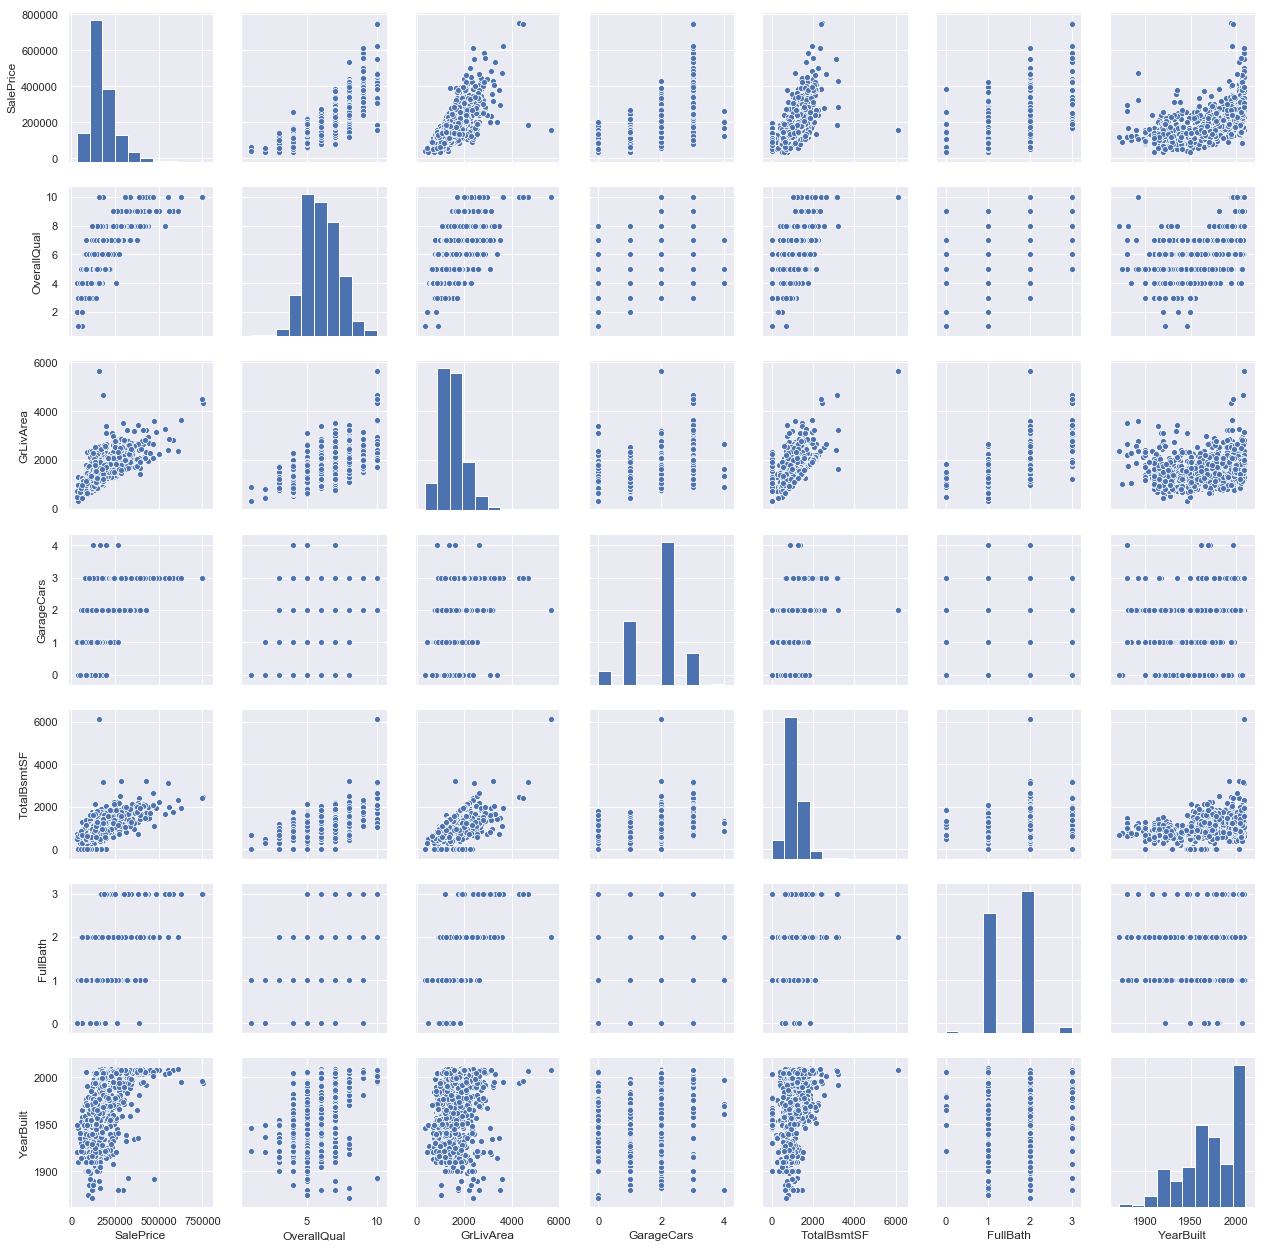

In [102]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

In [103]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [104]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [105]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


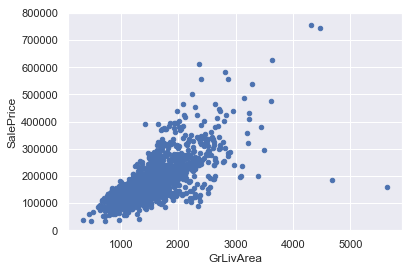

In [106]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [107]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


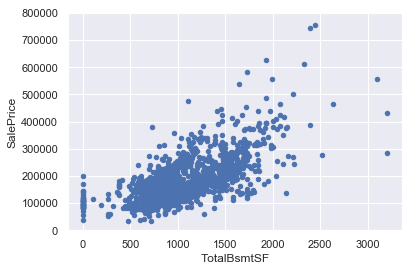

In [108]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

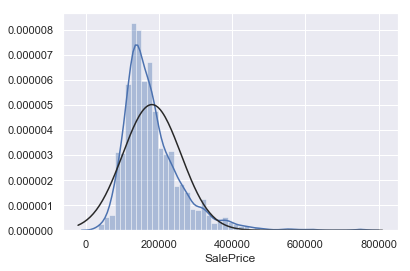

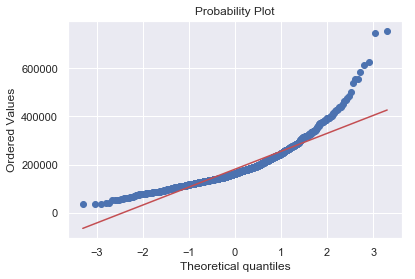

In [109]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

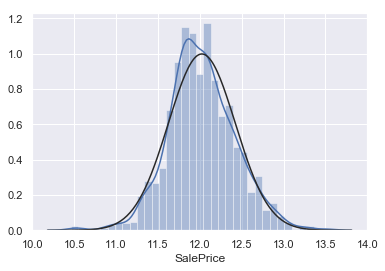

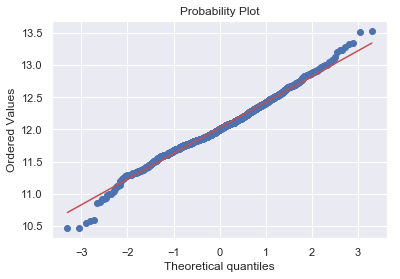

In [110]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

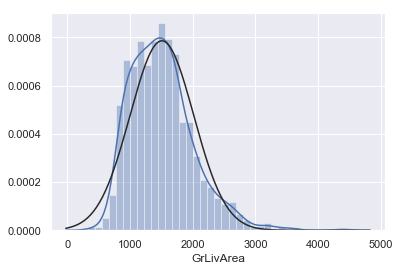

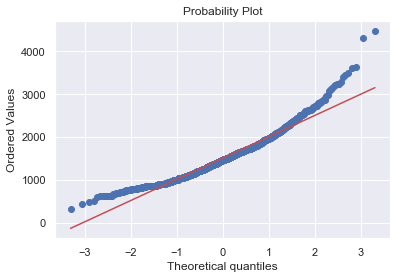

In [111]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

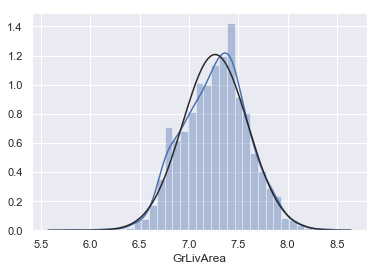

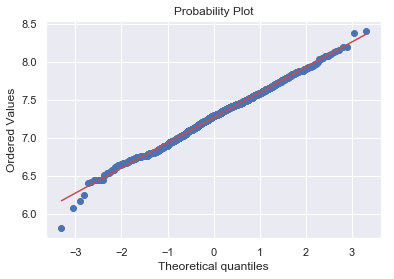

In [112]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [1]:
cd ..

/Users/hasegawatakashikana


In [2]:
cd Downloads/ieee-fraud-detection/

/Users/hasegawatakashikana/Downloads/ieee-fraud-detection


In [4]:
t = pd.read_csv("train_identity.csv")
t.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
d = pd.read_csv("train_transaction.csv")
d.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
pd.options.display.max_columns = None

In [7]:
t.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
